Grau dos vértices dos países - Transações Fraudulentas:
Australia: 13
Brazil: 20
USA: 22
South Africa: 19
Canada: 14
France: 16
Japan: 17
Germany: 9
UK: 18
India: 13

Soma dos pesos das arestas incidentes em cada país:
Australia: 6733.9800000000005
Brazil: 8298.94
USA: 11254.51
South Africa: 9210.79
Canada: 5999.84
France: 7811.82
Japan: 9424.72
Germany: 4114.28
UK: 9219.07
India: 7795.29


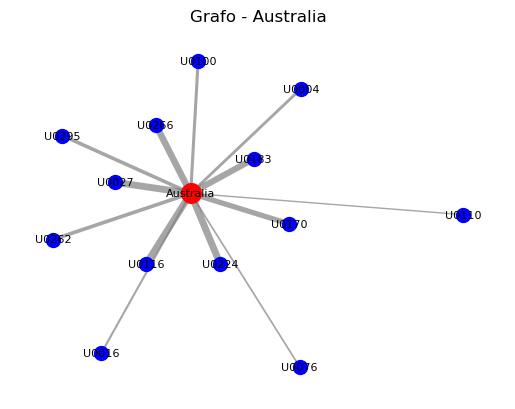

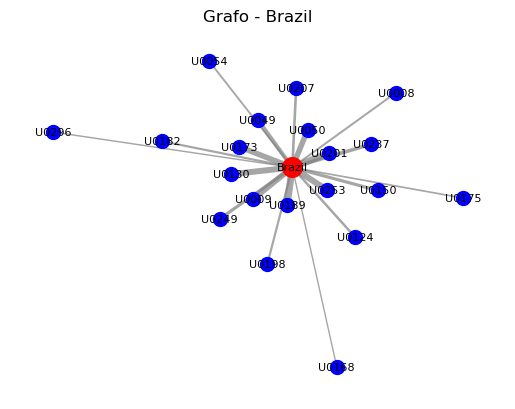

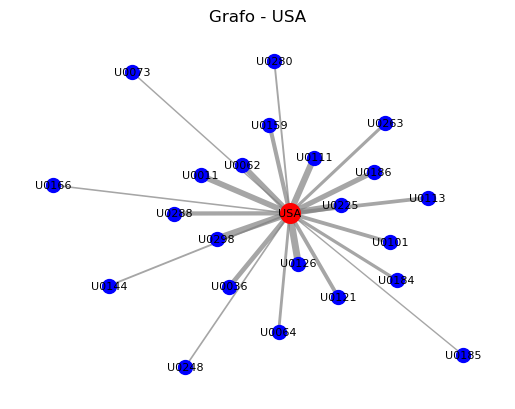

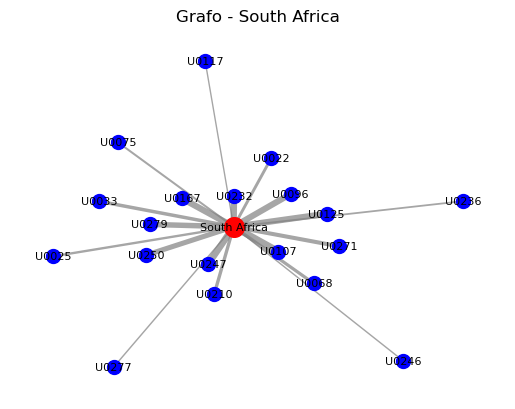

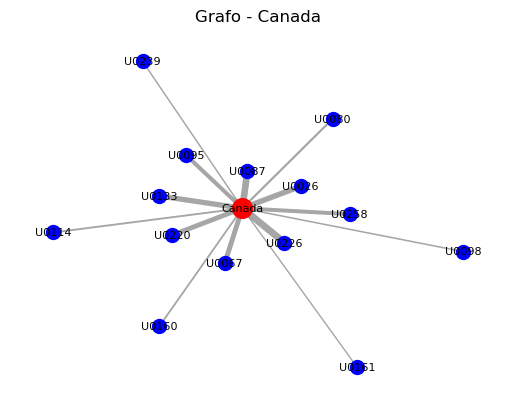

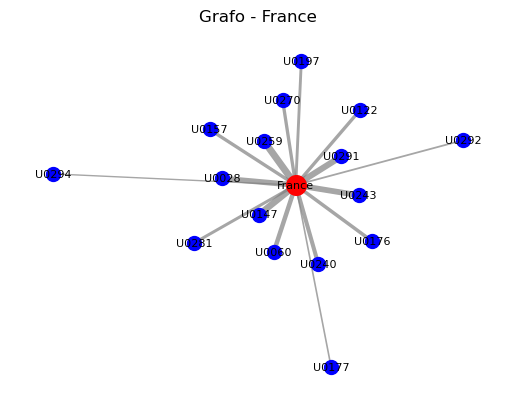

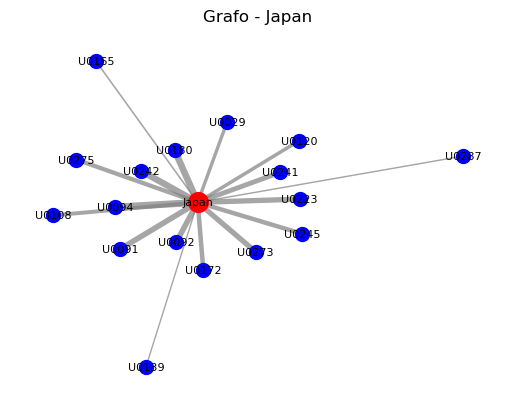

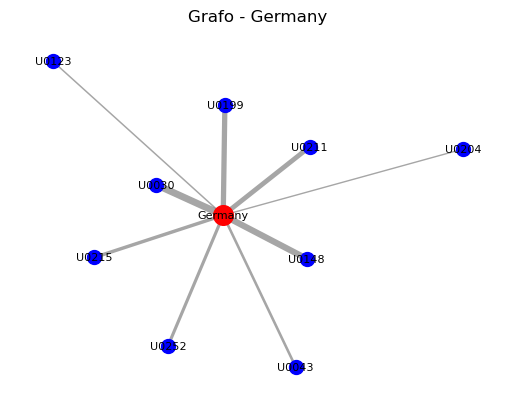

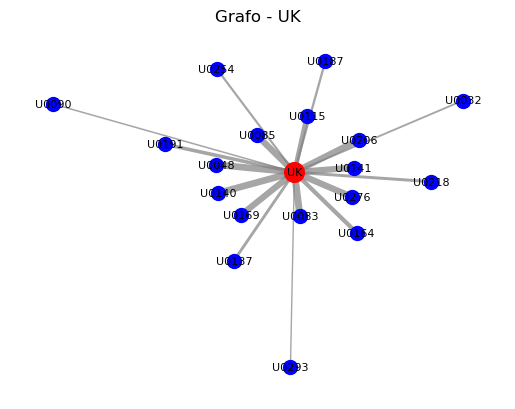

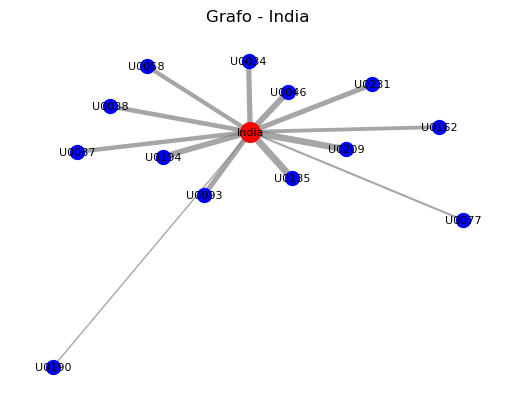

In [1]:
import pandas as pd                    # Importa a biblioteca pandas para manipulação de dados
import networkx as nx                  # Importa a biblioteca networkx para criação e manipulação de grafos
import matplotlib.pyplot as plt        # Importa a biblioteca matplotlib para plotagem dos gráficos

# Leitura do dataset a partir do arquivo CSV
# 'credit_card_fraud_detection.csv' é o nome do arquivo
# sep=',' especifica que o separador de colunas no CSV é a vírgula
df = pd.read_csv('credit_card_fraud_detection.csv', sep=',')

# Filtrar apenas as transações fraudulentas
# Seleciona as linhas onde a coluna 'Fraudulent' tem valor "Yes"
df = df[df['Fraudulent'] == 'Yes']

# Verifica se as colunas necessárias existem no DataFrame
# Define uma lista com os nomes das colunas obrigatórias
colunas_necessarias = ['User ID', 'Country', 'Transaction Amount', 'Fraudulent']
# Se alguma das colunas obrigatórias não estiver presente, levanta um erro
if not all(col in df.columns for col in colunas_necessarias):
    raise ValueError(f"O arquivo precisa conter as colunas: {colunas_necessarias}")

# Criação dos grafos separados por país
# Inicializa um dicionário para armazenar um grafo para cada país
country_graphs = {}

# Itera sobre cada país único encontrado na coluna 'Country'
for country in df['Country'].unique():
    G = nx.Graph()  # Cria um novo grafo não direcionado para o país atual
    # Filtra o DataFrame para selecionar apenas as transações do país atual
    df_country = df[df['Country'] == country]

    # Itera sobre cada transação (linha) do DataFrame filtrado
    for _, row in df_country.iterrows():
        client = row['User ID']                  # Obtém o ID do cliente da transação
        amount = row['Transaction Amount']       # Obtém o valor da transação que será usado como peso

        # Adiciona o nó representando o cliente e define seu atributo 'tipo' como 'cliente'
        G.add_node(client, tipo='cliente')
        # Adiciona o nó representando o país e define seu atributo 'tipo' como 'pais'
        G.add_node(country, tipo='pais')
        # Cria uma aresta entre o cliente e o país, atribuindo o valor da transação (amount) como peso
        G.add_edge(client, country, weight=amount)

    # Armazena o grafo criado no dicionário usando o nome do país como chave
    country_graphs[country] = G

# Função para plotar os grafos com espessura das arestas baseada no valor do peso (Transaction Amount)
def plot_graph(G, country):
    # Calcula as posições dos nós utilizando o layout "spring" (layout de força dirigida)
    # O parâmetro seed=42 garante a reprodutibilidade da disposição dos nós
    pos = nx.spring_layout(G, seed=42)
    
    # Cria uma lista com os nós do tipo 'cliente'
    clientes = [node for node, attr in G.nodes(data=True) if attr['tipo'] == 'cliente']

    # Desenha os nós dos clientes:
    # - pos: posições dos nós calculadas anteriormente
    # - nodelist: lista dos nós a serem desenhados (nós do tipo cliente)
    # - node_color: cor dos nós (azul)
    # - node_size: tamanho dos nós (100)
    nx.draw_networkx_nodes(G, pos, nodelist=clientes, node_color='blue', node_size=100)
    
    # Desenha o nó do país:
    # - nodelist: lista contendo apenas o nó do país
    # - node_color: cor dos nós (vermelho)
    # - node_size: tamanho do nó (200)
    nx.draw_networkx_nodes(G, pos, nodelist=[country], node_color='red', node_size=200)

    # Obtém os pesos das arestas armazenados no atributo 'weight'
    # O retorno é um dicionário onde as chaves são tuplas representando as arestas e os valores são os pesos
    weights = nx.get_edge_attributes(G, 'weight')
    
    # Converte os valores dos pesos para uma lista para facilitar a normalização
    all_weights = list(weights.values())
    
    # Determina o peso mínimo e máximo para normalizar os valores
    min_weight = min(all_weights)
    max_weight = max(all_weights)
    
    # Normaliza os pesos para definir a espessura das arestas:
    # Se todos os pesos forem iguais, evita divisão por zero e define a espessura como 1 para todas as arestas
    if max_weight == min_weight:
        widths = [1 for _ in all_weights]
    else:
        # Normalização: ((peso - min_weight) / (max_weight - min_weight)) gera um valor entre 0 e 1
        # Multiplica por 4 para ampliar a variação e soma 1 para que a espessura mínima seja 1
        widths = [(weight - min_weight) / (max_weight - min_weight) * 4 + 1 for weight in all_weights]

    # Desenha as arestas:
    # - edgelist: lista de arestas a serem desenhadas (as chaves do dicionário weights)
    # - width: lista de larguras para cada aresta, definida com base na normalização dos pesos
    # - edge_color: cor das arestas (cinza)
    # - alpha: transparência das arestas (0.7 para uma leve transparência)
    nx.draw_networkx_edges(G, pos, edgelist=weights.keys(), width=widths, edge_color='gray', alpha=0.7)

    # Desenha os rótulos (nomes) dos nós:
    # - font_size: tamanho da fonte dos rótulos (8)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Define o título do gráfico, indicando o país
    plt.title(f"Grafo - {country}")
    # Desativa os eixos para uma visualização mais limpa
    plt.axis('off')
    # Exibe o gráfico
    plt.show()

# Calcula e imprime o grau dos vértices dos países
# O grau do nó do país representa a quantidade de conexões (arestas) que ele possui
print("Grau dos vértices dos países - Transações Fraudulentas:")
for country, G in country_graphs.items():
    grau_pais = G.degree(country)   # Calcula o grau do nó correspondente ao país
    print(f"{country}: {grau_pais}")  # Exibe o nome do país e seu grau

# Soma os pesos das arestas que incidem sobre cada país e imprime o valor
print("\nSoma dos pesos das arestas incidentes em cada país:")
for country, G in country_graphs.items():
    # Obtém as arestas incidentes no nó do país com seus dados (atributos)
    incident_edges = G.edges(country, data=True)
    # Soma os valores dos pesos ('weight') para cada aresta incidente no nó do país
    total_weight = sum(data['weight'] for _, _, data in incident_edges)
    print(f"{country}: {total_weight}")

# Plota os grafos para cada país
# Itera sobre os itens do dicionário de grafos e chama a função plot_graph para cada país
for country, G in country_graphs.items():
    plot_graph(G, country)


Grau dos vértices dos países - Transações Fraudulentas:
Brazil: 6
USA: 6

Soma dos pesos das arestas incidentes em cada país:
Brazil: 8298.94
USA: 11254.51


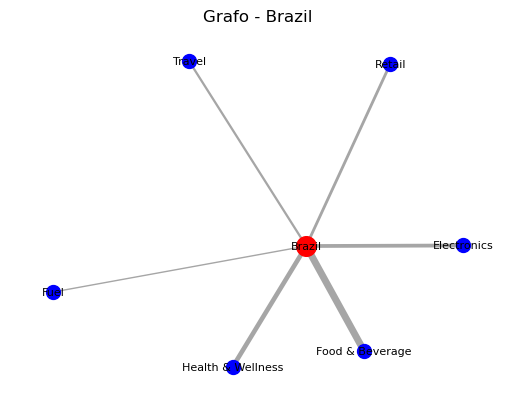

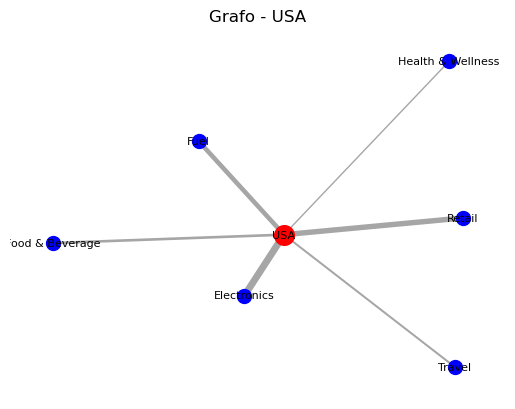

In [2]:
import pandas as pd                    # Importa a biblioteca pandas para manipulação de dados
import networkx as nx                  # Importa a biblioteca networkx para criação e manipulação de grafos
import matplotlib.pyplot as plt        # Importa a biblioteca matplotlib para plotagem dos gráficos

# Leitura do dataset a partir do arquivo CSV
# 'credit_card_fraud_detection.csv' é o nome do arquivo
# sep=',' especifica que o separador de colunas no CSV é a vírgula
df = pd.read_csv('credit_card_fraud_detection.csv', sep=',')

# Filtrar apenas as transações fraudulentas e dos países desejados (USA ou Brazil)
# Cada condição é avaliada element-wise e combinadas com & (e) e | (ou)
df = df[(df['Fraudulent'] == 'Yes') & ((df['Country'] == 'USA') | (df['Country'] == 'Brazil'))]

# Verifica se as colunas necessárias existem no DataFrame
colunas_necessarias = ['User ID', 'Country', 'Merchant Category', 'Fraudulent', 'Transaction Amount']
if not all(col in df.columns for col in colunas_necessarias):
    raise ValueError(f"O arquivo precisa conter as colunas: {colunas_necessarias}")

# Agrupa os dados por "Country" e "Merchant Category"
# e soma os valores de "Transaction Amount" para cada grupo.
# Dessa forma, cada categoria de mercado aparecerá apenas uma vez para cada país.
grouped = df.groupby(['Country', 'Merchant Category'])['Transaction Amount'].sum().reset_index()

# Criação dos grafos separados por país usando os dados agregados
country_graphs = {}

# Itera sobre cada país único no DataFrame agrupado
for country in grouped['Country'].unique():
    G = nx.Graph()  # Cria um novo grafo não direcionado para o país atual
    # Filtra o DataFrame agrupado para obter os dados do país atual
    df_country = grouped[grouped['Country'] == country]
    
    # Itera sobre cada linha do DataFrame filtrado
    for _, row in df_country.iterrows():
        merchant = row['Merchant Category']         # Obtém a categoria de mercado
        total_amount = row['Transaction Amount']      # Obtém a soma dos valores (peso da aresta)
        
        # Adiciona o nó representando a categoria de mercado com atributo 'tipo' como 'merchant'
        G.add_node(merchant, tipo='merchant')
        # Adiciona o nó representando o país com atributo 'tipo' como 'pais'
        G.add_node(country, tipo='pais')
        # Cria uma aresta entre a categoria de mercado e o país, atribuindo o valor agregado como peso
        G.add_edge(merchant, country, weight=total_amount)
    
    # Armazena o grafo criado no dicionário usando o nome do país como chave
    country_graphs[country] = G

# Função para plotar os grafos com espessura das arestas proporcional ao peso (soma dos valores)
def plot_graph(G, country):
    # Calcula as posições dos nós utilizando o layout "spring" (layout de força dirigida)
    # O parâmetro seed=42 garante reprodutibilidade na disposição dos nós
    pos = nx.spring_layout(G, seed=42)
    
    # Seleciona os nós do tipo 'merchant' (categorias de mercado)
    merchants = [node for node, attr in G.nodes(data=True) if attr['tipo'] == 'merchant']

    # Desenha os nós das categorias de mercado:
    # pos: posições dos nós calculadas anteriormente
    # nodelist: lista dos nós a serem desenhados (nós do tipo merchant)
    # node_color: cor dos nós (azul)
    # node_size: tamanho dos nós (100)
    nx.draw_networkx_nodes(G, pos, nodelist=merchants, node_color='blue', node_size=100)
    
    # Desenha o nó do país:
    # nodelist: lista contendo apenas o nó do país
    # node_color: cor do nó (vermelho)
    # node_size: tamanho do nó (200)
    nx.draw_networkx_nodes(G, pos, nodelist=[country], node_color='red', node_size=200)
    
    # Obtém os pesos das arestas armazenados no atributo 'weight'
    weights = nx.get_edge_attributes(G, 'weight')
    # Converte os valores dos pesos para uma lista para normalização
    all_weights = list(weights.values())
    
    # Determina o peso mínimo e máximo para normalizar os valores
    min_weight = min(all_weights)
    max_weight = max(all_weights)
    
    # Normaliza os pesos para definir a espessura das arestas
    if max_weight == min_weight:
        widths = [1 for _ in all_weights]
    else:
        # A fórmula mapeia os pesos para uma faixa (por exemplo, de 1 a 5)
        widths = [(weight - min_weight) / (max_weight - min_weight) * 4 + 1 for weight in all_weights]
    
    # Desenha as arestas:
    # edgelist: lista de arestas a serem desenhadas (as chaves do dicionário weights)
    # width: lista de larguras para cada aresta, baseada na normalização dos pesos
    # edge_color: cor das arestas (cinza)
    # alpha: transparência das arestas (0.7)
    nx.draw_networkx_edges(G, pos, edgelist=weights.keys(), width=widths, edge_color='gray', alpha=0.7)
    
    # Desenha os rótulos (nomes) dos nós com fonte tamanho 8
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Define o título do gráfico, indicando o país
    plt.title(f"Grafo - {country}")
    # Desativa os eixos para uma visualização mais limpa
    plt.axis('off')
    # Exibe o gráfico
    plt.show()

# Exibe informações dos grafos
print("Grau dos vértices dos países - Transações Fraudulentas:")
for country, G in country_graphs.items():
    grau_pais = G.degree(country)   # Calcula o grau do nó do país
    print(f"{country}: {grau_pais}")

print("\nSoma dos pesos das arestas incidentes em cada país:")
for country, G in country_graphs.items():
    # Obtém as arestas incidentes no nó do país, com seus dados
    incident_edges = G.edges(country, data=True)
    # Soma os pesos ('weight') de cada aresta incidente
    total_weight = sum(data['weight'] for _, _, data in incident_edges)
    print(f"{country}: {total_weight}")

# Plota os grafos para cada país
for country, G in country_graphs.items():
    plot_graph(G, country)
